<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [6]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [7]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  print((1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]))
  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

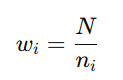

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [8]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [9]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 3:
    googlenet = models.googlenet(weights="IMAGENET1K_V1")
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 4:
    efficientnet = models.efficientnet_b3(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.fc.in_features
    efficientnet.fc = nn.Linear(in_features=num_features, out_features=1)
    return efficientnet,loss_fn

  elif numero_model == 5:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  elif numero_model == 6:

    resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass.fc.in_features
    resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass,loss_fn

  elif numero_model == 7:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 8:

    googlenetmulticlass = models.googlenet(weights="IMAGENET1K_V1")

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 9:

    efficientnetmulticlass = models.efficientnet_b3(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [10]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [11]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [12]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [13]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 10
  requerit = 0.015
  last_f1 = 0

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_f1 + requerit > train_f1:
            torch.save(model.state_dict(), 'best_model.pt')
            print("Early Stopping, no hem pujat ni un 2% d'f1-score respecte 10 èpoques!!")
            break
        else:
          interval = 10
          last_f1 = train_f1


  wandb.finish()

In [14]:
def test(model,dataloader,weights_dir,loss_fn,device):
  model.load_state_dict(torch.load(weights_dir))
  test_acc,test_f1,test_recall,test_precision,test_loss  = validate(model,loss_fn,dataloader,device)

  if WEIGHTSANDBIASES:
    test_metrics = {"test/test_loss": test_loss/len(dataloader),
                      "test/test_acc":test_acc/len(dataloader),
                      "test/test_f1":test_f1/len(dataloader),
                      "test/test_recall": test_recall/len(dataloader),
                      "test/test_precision": test_precision/len(dataloader)}

    wandb.log({**test_metrics})

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2,'googlenet':3,'efficientnet':4,'alexnetmulticlass':5,'resnet50multiclass':6,'resnet150multiclass':7,'googlenetmulticlass':8,'efficientnetmulticlass':9}
MODEL = architectures['resnet']

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
increment = 1.0
binary_weights, multiple_weights = get_weights()

if MODEL < 5:
  WEIGHTS = [binary_weights]
  print(WEIGHTS)
else:
  WEIGHTS = [multiple_weights]


learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary','Ham10000-GoogleNetBinary','Ham10000-EfficientNetBinary',
               'Ham10000-AlexnetMulticlass','Ham10000ResnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-GoogleNetMulticlass','Ham10000-EfficientNetMulticlass']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
  test(model,test_loader,"/content/best_model.pt",loss_fn,device)

0    5363
1     891
2     879
3     411
4     261
5     114
6      92
Name: count, dtype: int64
8011
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
2.845929572315279
[2.845929572315279]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [2.845929572315279]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.6374494442901764
Accuracy train epoch: 1  train_acc: 0.7811481347337921
F1 train epoch: 1  train_f1: 0.8002325949453865
Recall train epoch: 1  train_recall: 0.7811481347337921


Pèrdua validació epoch: 1  val_loss: 0.4977810017298907
Accuracy val epoch: 1  val_acc: 0.8642578125
F1 val epoch: 1  val_f1: 0.8684085707752587
Recall val epoch: 1  val_recall: 0.8642578125
Recall val epoch: 1  val_precision: 0.8835305080183589


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.48671734760482
Accuracy train epoch: 2  train_acc: 0.8438971387178559
F1 train epoch: 2  train_f1: 0.8567253243955403
Recall train epoch: 2  train_recall: 0.8438971387178559


Pèrdua validació epoch: 2  val_loss: 0.44411833211779594
Accuracy val epoch: 2  val_acc: 0.8650390625
F1 val epoch: 2  val_f1: 0.871387282460667
Recall val epoch: 2  val_recall: 0.8650390625
Recall val epoch: 2  val_precision: 0.8899182017928998


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.43652548643934774
Accuracy train epoch: 3  train_acc: 0.862312115175661
F1 train epoch: 3  train_f1: 0.872985992842569
Recall train epoch: 3  train_recall: 0.862312115175661


Pèrdua validació epoch: 3  val_loss: 0.44148830603808165
Accuracy val epoch: 3  val_acc: 0.86796875
F1 val epoch: 3  val_f1: 0.8731015431091415
Recall val epoch: 3  val_recall: 0.86796875
Recall val epoch: 3  val_precision: 0.8856916071517801


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3906551312759103
Accuracy train epoch: 4  train_acc: 0.8787463781238681
F1 train epoch: 4  train_f1: 0.8875011536754449
Recall train epoch: 4  train_recall: 0.8787463781238681


Pèrdua validació epoch: 4  val_loss: 0.46225800714455545
Accuracy val epoch: 4  val_acc: 0.8904296875
F1 val epoch: 4  val_f1: 0.8909291510432205
Recall val epoch: 4  val_recall: 0.8904296875
Recall val epoch: 4  val_precision: 0.899554132501016


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.34887974361974405
Accuracy train epoch: 5  train_acc: 0.8961766570083303
F1 train epoch: 5  train_f1: 0.9028756108139707
Recall train epoch: 5  train_recall: 0.8961766570083303


Pèrdua validació epoch: 5  val_loss: 0.41765059996396303
Accuracy val epoch: 5  val_acc: 0.89921875
F1 val epoch: 5  val_f1: 0.8990250877268753
Recall val epoch: 5  val_recall: 0.89921875
Recall val epoch: 5  val_precision: 0.9091633556723571


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3228009883685416
Accuracy train epoch: 6  train_acc: 0.9053898044186889
F1 train epoch: 6  train_f1: 0.9124008100825128
Recall train epoch: 6  train_recall: 0.9053898044186889


Pèrdua validació epoch: 6  val_loss: 0.40630154468817636
Accuracy val epoch: 6  val_acc: 0.8876953125
F1 val epoch: 6  val_f1: 0.8913902843497582
Recall val epoch: 6  val_recall: 0.8876953125
Recall val epoch: 6  val_precision: 0.9048037236955375


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.28880052354587504
Accuracy train epoch: 7  train_acc: 0.9134824339007606
F1 train epoch: 7  train_f1: 0.9188036681171969
Recall train epoch: 7  train_recall: 0.9134824339007606


Pèrdua validació epoch: 7  val_loss: 0.41982055571861565
Accuracy val epoch: 7  val_acc: 0.896484375
F1 val epoch: 7  val_f1: 0.8998819097698456
Recall val epoch: 7  val_recall: 0.896484375
Recall val epoch: 7  val_precision: 0.9125611078434283


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.26879183134709694
Accuracy train epoch: 8  train_acc: 0.9255478087649402
F1 train epoch: 8  train_f1: 0.9305762672055203
Recall train epoch: 8  train_recall: 0.9255478087649402


Pèrdua validació epoch: 8  val_loss: 0.49689168843906373
Accuracy val epoch: 8  val_acc: 0.901953125
F1 val epoch: 8  val_f1: 0.90080601510888
Recall val epoch: 8  val_recall: 0.901953125
Recall val epoch: 8  val_precision: 0.9112963987800519


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.2531926538127352
Accuracy train epoch: 9  train_acc: 0.9298035132198479
F1 train epoch: 9  train_f1: 0.934070862836213
Recall train epoch: 9  train_recall: 0.9298035132198479


Pèrdua validació epoch: 9  val_loss: 0.4123659951146692
Accuracy val epoch: 9  val_acc: 0.89140625
F1 val epoch: 9  val_f1: 0.8955624912824182
Recall val epoch: 9  val_recall: 0.89140625
Recall val epoch: 9  val_precision: 0.9086027943583566


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.2172916521915639
Accuracy train epoch: 10  train_acc: 0.9382583303151032
F1 train epoch: 10  train_f1: 0.9416579047188277
Recall train epoch: 10  train_recall: 0.9382583303151032


Pèrdua validació epoch: 10  val_loss: 0.528036056086421
Accuracy val epoch: 10  val_acc: 0.8921875
F1 val epoch: 10  val_f1: 0.8914410279603686
Recall val epoch: 10  val_recall: 0.8921875
Recall val epoch: 10  val_precision: 0.8955659994071868


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.20164989605100744
Accuracy train epoch: 11  train_acc: 0.9443589279246649
F1 train epoch: 11  train_f1: 0.9475120564299326
Recall train epoch: 11  train_recall: 0.9443589279246649


Pèrdua validació epoch: 11  val_loss: 0.4667753779795021
Accuracy val epoch: 11  val_acc: 0.9001953125
F1 val epoch: 11  val_f1: 0.9002307514593042
Recall val epoch: 11  val_recall: 0.9001953125
Recall val epoch: 11  val_precision: 0.9093110176602317


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.2047768699309503
Accuracy train epoch: 12  train_acc: 0.9447437522636726
F1 train epoch: 12  train_f1: 0.9480707194257418
Recall train epoch: 12  train_recall: 0.9447437522636726


Pèrdua validació epoch: 12  val_loss: 0.5000600693747401
Accuracy val epoch: 12  val_acc: 0.905078125
F1 val epoch: 12  val_f1: 0.9042609187598464
Recall val epoch: 12  val_recall: 0.905078125
Recall val epoch: 12  val_precision: 0.9132506829822382


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.17328123951635038
Accuracy train epoch: 13  train_acc: 0.9519535494386092
F1 train epoch: 13  train_f1: 0.9545386596654187
Recall train epoch: 13  train_recall: 0.9519535494386092


Pèrdua validació epoch: 13  val_loss: 0.3955439809942618
Accuracy val epoch: 13  val_acc: 0.901171875
F1 val epoch: 13  val_f1: 0.9056780744838633
Recall val epoch: 13  val_recall: 0.901171875
Recall val epoch: 13  val_precision: 0.9189075798302192


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.1576028363148411
Accuracy train epoch: 14  train_acc: 0.9572958167330677
F1 train epoch: 14  train_f1: 0.9598367463709804
Recall train epoch: 14  train_recall: 0.9572958167330677


Pèrdua validació epoch: 14  val_loss: 0.5119055537506938
Accuracy val epoch: 14  val_acc: 0.9033203125
F1 val epoch: 14  val_f1: 0.9045637918141666
Recall val epoch: 14  val_recall: 0.9033203125
Recall val epoch: 14  val_precision: 0.9117257929604126


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.1586258343357845
Accuracy train epoch: 15  train_acc: 0.956944947482796
F1 train epoch: 15  train_f1: 0.9595572049092683
Recall train epoch: 15  train_recall: 0.956944947482796


Pèrdua validació epoch: 15  val_loss: 0.43415145482867956
Accuracy val epoch: 15  val_acc: 0.9072265625
F1 val epoch: 15  val_f1: 0.9102637180795707
Recall val epoch: 15  val_recall: 0.9072265625
Recall val epoch: 15  val_precision: 0.9187552229531605


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.14261083906345753
Accuracy train epoch: 16  train_acc: 0.9620495291561029
F1 train epoch: 16  train_f1: 0.9639910196512643
Recall train epoch: 16  train_recall: 0.9620495291561029


Pèrdua validació epoch: 16  val_loss: 0.49399042152799666
Accuracy val epoch: 16  val_acc: 0.908984375
F1 val epoch: 16  val_f1: 0.9109347898114878
Recall val epoch: 16  val_recall: 0.908984375
Recall val epoch: 16  val_precision: 0.9205557454101102


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.1322971604675411
Accuracy train epoch: 17  train_acc: 0.9652639442231076
F1 train epoch: 17  train_f1: 0.9670977558580438
Recall train epoch: 17  train_recall: 0.9652639442231076


Pèrdua validació epoch: 17  val_loss: 0.44062994117848575
Accuracy val epoch: 17  val_acc: 0.9111328125
F1 val epoch: 17  val_f1: 0.9125745668796071
Recall val epoch: 17  val_recall: 0.9111328125
Recall val epoch: 17  val_precision: 0.9178858798300883


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.10982560738921165
Accuracy train epoch: 18  train_acc: 0.9716135458167331
F1 train epoch: 18  train_f1: 0.9729797771853108
Recall train epoch: 18  train_recall: 0.9716135458167331


Pèrdua validació epoch: 18  val_loss: 0.4998179701215122
Accuracy val epoch: 18  val_acc: 0.9140625
F1 val epoch: 18  val_f1: 0.913381265136229
Recall val epoch: 18  val_recall: 0.9140625
Recall val epoch: 18  val_precision: 0.9207800236199682


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.11567558067297912
Accuracy train epoch: 19  train_acc: 0.9693838283230714
F1 train epoch: 19  train_f1: 0.9711758004419232
Recall train epoch: 19  train_recall: 0.9693838283230714


Pèrdua validació epoch: 19  val_loss: 0.4662391210440546
Accuracy val epoch: 19  val_acc: 0.908984375
F1 val epoch: 19  val_f1: 0.9130040420788927
Recall val epoch: 19  val_recall: 0.908984375
Recall val epoch: 19  val_precision: 0.9254942709795876


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.10428115713643837
Accuracy train epoch: 20  train_acc: 0.9733678920680913
F1 train epoch: 20  train_f1: 0.9748665534734963
Recall train epoch: 20  train_recall: 0.9733678920680913


Pèrdua validació epoch: 20  val_loss: 0.5588117158040404
Accuracy val epoch: 20  val_acc: 0.91484375
F1 val epoch: 20  val_f1: 0.9150347338995485
Recall val epoch: 20  val_recall: 0.91484375
Recall val epoch: 20  val_precision: 0.9199815677346541


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.09843671389770105
Accuracy train epoch: 21  train_acc: 0.9753599239406012
F1 train epoch: 21  train_f1: 0.9764390434525129
Recall train epoch: 21  train_recall: 0.9753599239406012


Pèrdua validació epoch: 21  val_loss: 0.4629156809533015
Accuracy val epoch: 21  val_acc: 0.909765625
F1 val epoch: 21  val_f1: 0.912991224769337
Recall val epoch: 21  val_recall: 0.909765625
Recall val epoch: 21  val_precision: 0.9225441225833971


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.09404926711463359
Accuracy train epoch: 22  train_acc: 0.9747260956175299
F1 train epoch: 22  train_f1: 0.976234702679939
Recall train epoch: 22  train_recall: 0.9747260956175299


Pèrdua validació epoch: 22  val_loss: 0.5506580701330677
Accuracy val epoch: 22  val_acc: 0.9111328125
F1 val epoch: 22  val_f1: 0.9127774334783385
Recall val epoch: 22  val_recall: 0.9111328125
Recall val epoch: 22  val_precision: 0.9223554836360837


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.0925231453242797
Accuracy train epoch: 23  train_acc: 0.9744884099963781
F1 train epoch: 23  train_f1: 0.9760756752328247
Recall train epoch: 23  train_recall: 0.9744884099963781


Pèrdua validació epoch: 23  val_loss: 0.5534908606787212
Accuracy val epoch: 23  val_acc: 0.916015625
F1 val epoch: 23  val_f1: 0.9154743292809097
Recall val epoch: 23  val_recall: 0.916015625
Recall val epoch: 23  val_precision: 0.9225024284887565


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.08446242506300429
Accuracy train epoch: 24  train_acc: 0.977589641434263
F1 train epoch: 24  train_f1: 0.9787535851625652
Recall train epoch: 24  train_recall: 0.977589641434263


Pèrdua validació epoch: 24  val_loss: 0.6743845823220909
Accuracy val epoch: 24  val_acc: 0.9138671875
F1 val epoch: 24  val_f1: 0.9101481434519614
Recall val epoch: 24  val_recall: 0.9138671875
Recall val epoch: 24  val_precision: 0.9191996573751195


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.08427963904160783
Accuracy train epoch: 25  train_acc: 0.9787214777254618
F1 train epoch: 25  train_f1: 0.9801044208988074
Recall train epoch: 25  train_recall: 0.9787214777254618


Pèrdua validació epoch: 25  val_loss: 0.5241100629791617
Accuracy val epoch: 25  val_acc: 0.9169921875
F1 val epoch: 25  val_f1: 0.9180959014689914
Recall val epoch: 25  val_recall: 0.9169921875
Recall val epoch: 25  val_precision: 0.9256586131799597


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.06945480924448466
Accuracy train epoch: 26  train_acc: 0.9840637450199203
F1 train epoch: 26  train_f1: 0.9850462262428665
Recall train epoch: 26  train_recall: 0.9840637450199203


Pèrdua validació epoch: 26  val_loss: 0.6165998533833772
Accuracy val epoch: 26  val_acc: 0.916015625
F1 val epoch: 26  val_f1: 0.914013854663978
Recall val epoch: 26  val_recall: 0.916015625
Recall val epoch: 26  val_precision: 0.9241662533128371


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.06944681092933473
Accuracy train epoch: 27  train_acc: 0.9810756972111554
F1 train epoch: 27  train_f1: 0.9820097292864328
Recall train epoch: 27  train_recall: 0.9810756972111554


Pèrdua validació epoch: 27  val_loss: 0.6205192073248327
Accuracy val epoch: 27  val_acc: 0.9126953125
F1 val epoch: 27  val_f1: 0.9107882231743156
Recall val epoch: 27  val_recall: 0.9126953125
Recall val epoch: 27  val_precision: 0.9170991952876443


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.07054671732174507
Accuracy train epoch: 28  train_acc: 0.9816982071713147
F1 train epoch: 28  train_f1: 0.982599826095979
Recall train epoch: 28  train_recall: 0.9816982071713147


Pèrdua validació epoch: 28  val_loss: 0.5683199797786074
Accuracy val epoch: 28  val_acc: 0.9150390625
F1 val epoch: 28  val_f1: 0.9126391639713385
Recall val epoch: 28  val_recall: 0.9150390625
Recall val epoch: 28  val_precision: 0.9175491924188717


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.06622870256233797
Accuracy train epoch: 29  train_acc: 0.9828300434625136
F1 train epoch: 29  train_f1: 0.9837313627536793
Recall train epoch: 29  train_recall: 0.9828300434625136


Pèrdua validació epoch: 29  val_loss: 0.50760936900042
Accuracy val epoch: 29  val_acc: 0.921484375
F1 val epoch: 29  val_f1: 0.9211115772918336
Recall val epoch: 29  val_recall: 0.921484375
Recall val epoch: 29  val_precision: 0.9268639332606445


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.062047059006758956
Accuracy train epoch: 30  train_acc: 0.983441235059761
F1 train epoch: 30  train_f1: 0.9842434973216064
Recall train epoch: 30  train_recall: 0.983441235059761


Pèrdua validació epoch: 30  val_loss: 0.5702006614301354
Accuracy val epoch: 30  val_acc: 0.921875
F1 val epoch: 30  val_f1: 0.9216756163141893
Recall val epoch: 30  val_recall: 0.921875
Recall val epoch: 30  val_precision: 0.9313914709320906
Early Stopping, no hem pujat ni un 2% d'f1-score respecte 10 èpoques!!


train/train_acc,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇███████████
train/train_f1,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇█▇███████████
train/train_loss,█▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███████████
train/train_recall,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇███████████
val/val_acc,▁▁▁▄▅▄▅▆▄▄▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇██
val/val_f1,▁▁▂▄▅▄▅▅▅▄▅▆▆▆▇▇▇▇▇▇▇▇▇▆█▇▇▇██
val/val_loss,▄▂▂▃▂▁▂▄▁▄▃▄▁▄▂▃▂▄▃▅▃▅▅█▄▇▇▅▄▅
val/val_precision,▁▂▁▃▅▄▅▅▅▃▅▅▆▅▆▆▆▆▇▆▇▇▇▆▇▇▆▆▇█
val/val_recall,▁▁▁▄▅▄▅▆▄▄▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇██
train/train_acc,0.98344


<ipython-input-14-9bf2008f8092>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


Error: You must call wandb.init() before wandb.log()